# Sentiment Prediction Model in Film Reviews Using Natural Language Processing  <a id='intro'></a>

An entertainment company wants to build a `machine learning` model to filter the reviews of a `movie` and categorize them. The reviews should be able to identify whether they are `positive reviews` or `negative reviews`. We will use the `dataset` of reviews from `IMDB` with `polarity labeling` to create a model that can classify `positive` and `negative` reviews. This model should have at least an `F1` score of `0.85`. We will explore the dataset using `exploratory data analysis (EDA)` to get `insights` in it and ensure that `dataset` can train the model properly. Some of the `models` with their `configurations` that we will train and test include:
- Model 0 - Constant (*Dummy Classifier*)
- Model 1 - NLTK, TF-IDF and *Logistic Regression*
- Model 2 - spaCy, TF-IDF and *Logistic Regression*
- Model 3 - spaCy, TF-IDF and LGBMClassifier
- Model 4 - BERT (*Bidirectional Encoder Representations from Transformers*) and *Logistic Regression*

# Content <a id='back'></a>

* [Intro](#intro)
* [Content](#back)
* [Stage 1. Initialization](#cont_1)
* [Stage 2. Load the Data](#cont_2)
* [Stage 3. Exploratory Data Analysis (EDA)](#cont_3)
* [Stage 4. Evaluation Procedure](#cont_4)
* [Stage 5. Normalization](#cont_5)
* [Stage 6. Train / Test Separation](#cont_6)
* [Stage 7. Working with Models](#cont_7)
    * [7.1 Model 0 - Constant](#cont_8)
    * [7.2 Model 1 - NLTK, TF-IDF and LR](#cont_9)
    * [7.3 Model 2 - spaCy, TF-IDF and LR](#cont_10)
    * [7.4 Model 3 - spaCy, TF-IDF and LGBMClassifier](#cont_11)
    * [7.5 Model 4 - BERT (Bidirectional Encoder Representations from Transformers) and LR](#cont_12)
        * [7.5.1 Small Number of Samples](#cont_13)
        * [7.5.2 Large Number of Samples](#cont_14)
* [Stage 8. Custom Reviews](#cont_15)
    * [8.1 Model 1](#cont_16)
    * [8.2 Model 2](#cont_17)
    * [8.3 Model 3](#cont_18)
    * [8.4 Model 5](#cont_19)
* [Stage 9. Conclusion](#cont_20)

## Initialization <a id='cont_1'></a>

We will run several modules such as `pandas`, `numpy`, `seaborn` and others. Several other modules will be loaded in certain sessions.

In [21]:
# load several modules
import math
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm

# jupyter notebook configuration
tqdm.pandas()
sns.set_theme(palette='bright')

## Load the Data <a id='cont_2'></a>

The dataset is stored in the `imdb_reviews.tsv` file, we will load it.

In [22]:
# load the dataset
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [23]:
# displays dataset information
print(df_reviews.info())

# displays samples of dataset
df_reviews.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


The dataset contains the following columns:

- `tconst` — unique ID for each entity in IMDB database.
- `title_type` — the title type of the entity (eg movie, TV series, etc.).
- `primary_title` — main title of the entity.
- `original_title` — the original title of the entity (for example, the title in the original language).
- `start_year` — the year the entity was released.
- `end_year` — year of end of release (if applicable), or special flag if entity is continuing.
- `runtime_minutes` — entity duration in minutes.
- `is_adult` — an indicator of whether the entity includes adult content (1 for yes, 0 for no).
- `genres` — genres associated with the entity (separated by commas).
- `average_rating` — the average rating value of the entity.
- `votes` — the number of votes or reviews received by the entity.
- `review` — review or review related to the entity.
- `rating` — the entity's rating value.
- `sp` — text of positive or negative review.
- `post` — numeric of positive or negative reviews.
- `ds_part` — source entity dataset from train or test.
- `idx` — a unique index number that represents a specific row in the dataset.

In [24]:
# check the duplicated dataset
df_reviews.duplicated().sum()

0

Based on a basic observation of loading the dataset, we know that the total data is `47331 rows` and `17 columns`. This dataset has some `missing values` in the `average_rating` and `votes` columns, we will not process the `missing values` because only a few rows are missing and not the main column for processing `natural language processing (NLP)`. This dataset also does not have duplicate data so we can process it further.

## Exploratory Data Analysis (EDA) <a id='cont_3'></a>

Next, we will perform EDA by creating visualizations for the distribution of `number of movies`, distribution of `number of reviews per movies`, number of `ratings` based on datasets (`training` and `test`), and comparison of the number of reviews ( `positive` or `negative`) based on the datasets (`training` and `test`).

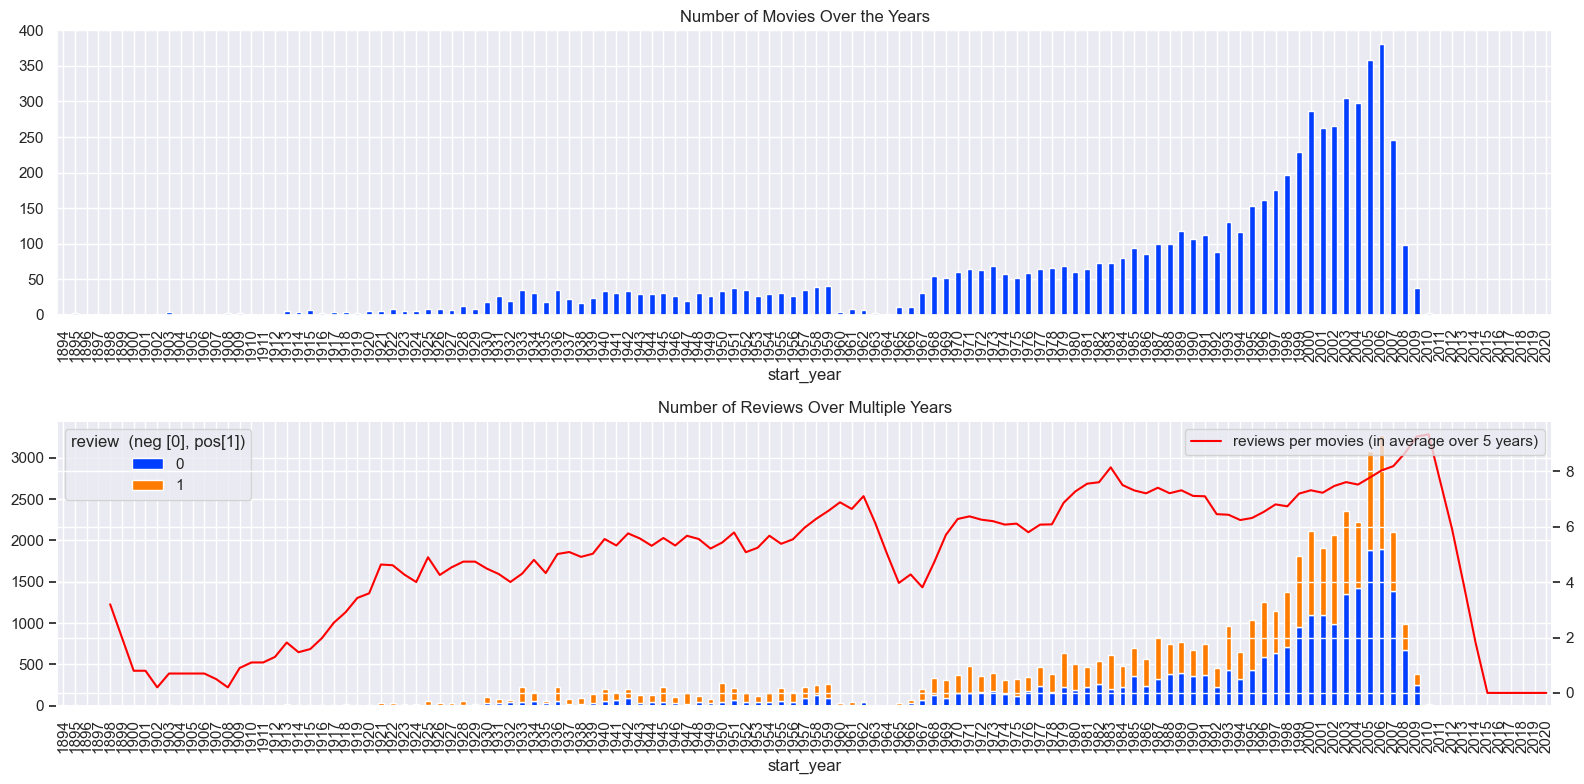

In [25]:
# create a plot for the distribution of the number of movies
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# plot for the number of movies
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over the Years')

# plot for the number of reviews (negative and positive)
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2.rename_axis('review  (neg [0], pos[1])',axis="columns",inplace=True)
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, ax=ax)

# plot the average number of movies for 5 years
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='red', label='reviews per movies (in average over 5 years)', ax=axt)
plt.legend(loc="upper right")

ax.set_title('Number of Reviews Over Multiple Years') 
fig.tight_layout()

Based on the graph above, we can conclude that almost `every year there has been an increase in the number of movies` followed by `increasing number of reviews` for the movie with a ratio of `positive reviews` and `negative reviews` which is almost `balanced` until `2006`. The average number of reviews every `5 years` shows a `trend` which is `slightly increasing` from previous years to the highest average peak of `2010` more than `3000 reviews`.

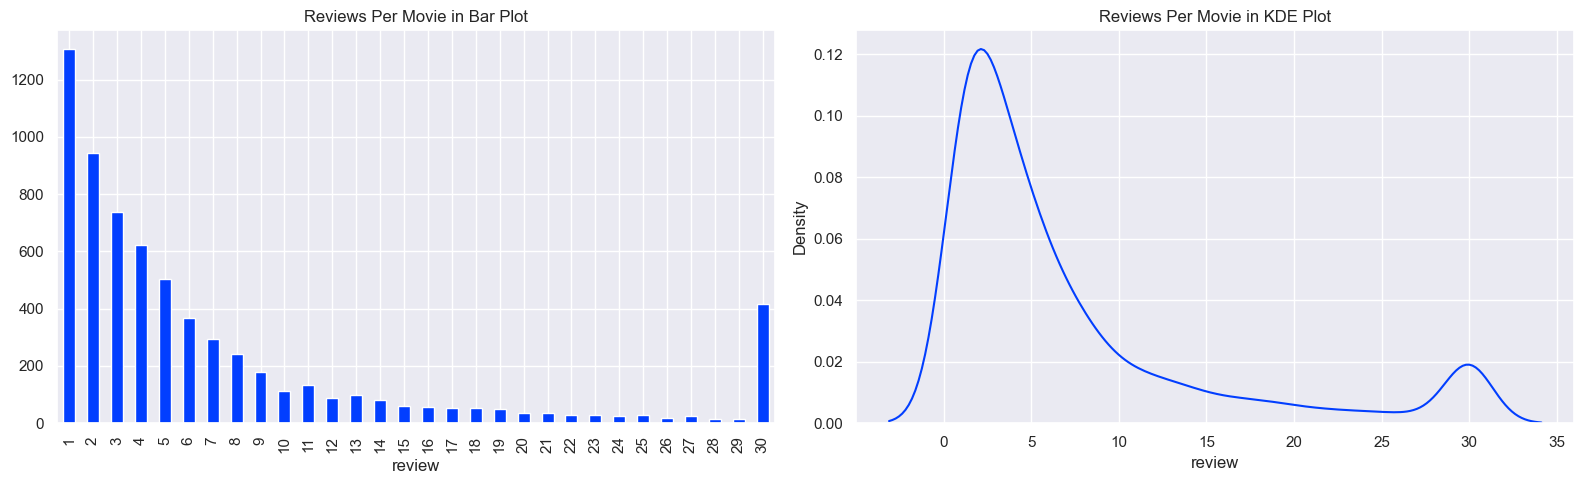

In [26]:
# plot the distribution of the number of reviews per movie
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Reviews Per Movie in Bar Plot')
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Reviews Per Movie in KDE Plot') 

fig.tight_layout()

Based on the graph above, the average movie has mostly reviews of `1-5 reviews/movie`, followed by movies that have reviews of `30 reviews/movie` and followed after that.

In [27]:
# calculate the balance of review class (negative [0] and positive[1])
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

We can see that we have an almost equal number of classes for the classification model with `negative reviews [0]` and `negative reviews [1]`.

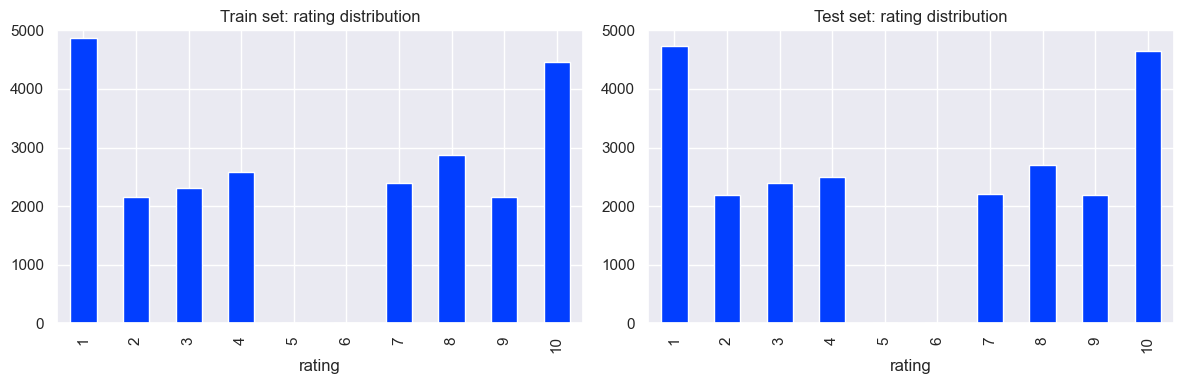

In [28]:
# plot the rating distribution on the training dataset and test dataset
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: rating distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: rating distribution')

fig.tight_layout()

Here, we can also see a balanced comparison of the number of `movie ratings`, both for the `training` dataset and the `test` dataset. It can be seen that the highest number of ratings are `1 and 10` for both datasets.

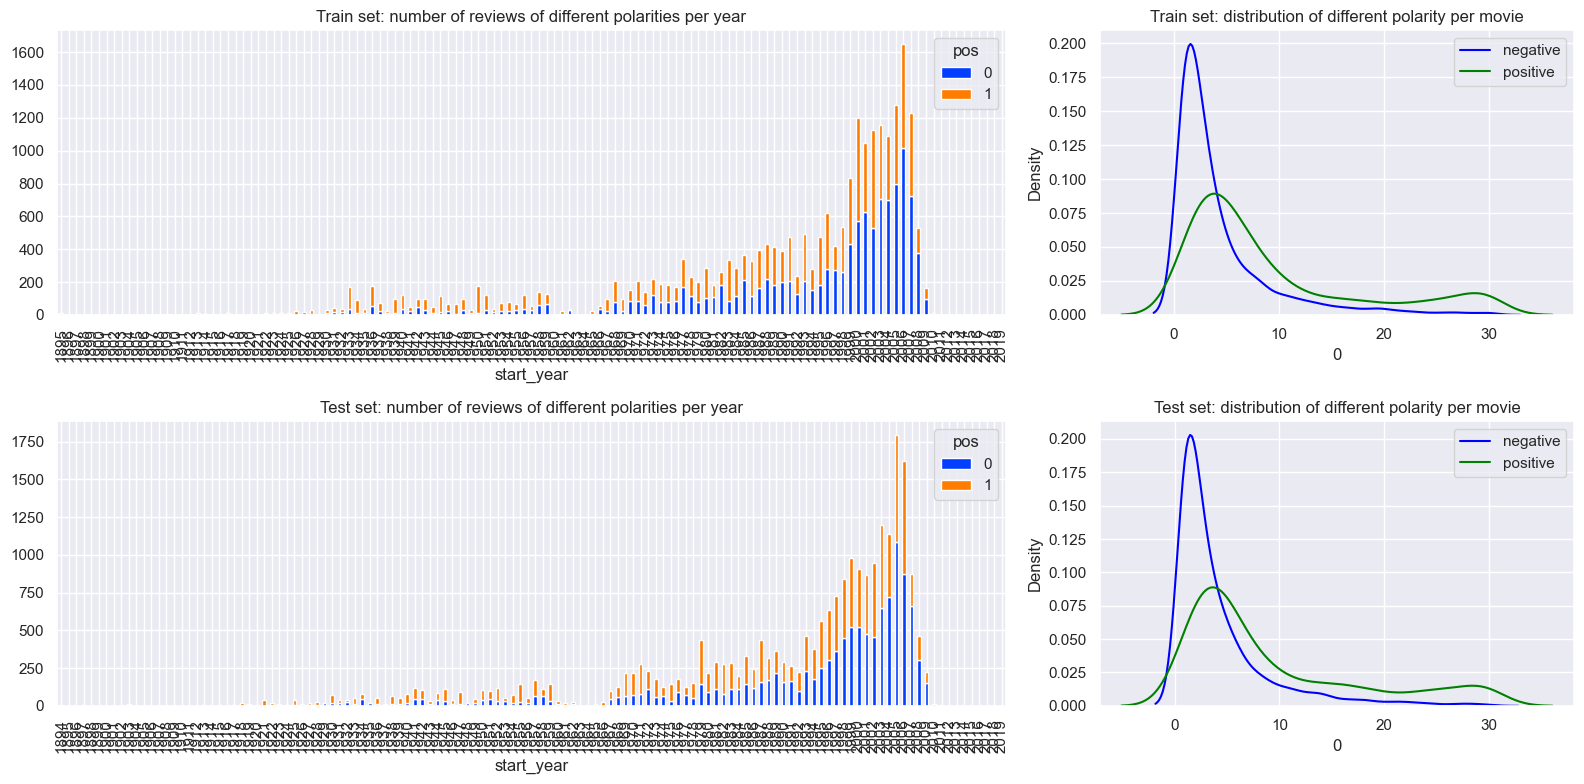

In [29]:
# create a comparative plot of the number of reviews (negative [0] and positive[1]) based on training and test datasets
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Train set: distribution of different polarity per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Test set: distribution of different polarity per movie')

fig.tight_layout()

Here, we can see that the forms of the `training` and `test` datasets are similar based on the number of `positive reviews` and the number of `negative reviews`. A nearly even comparison of the number of `positive` reviews and the number of `negative` reviews for each dataset. This means that we can directly use this dataset as a training model and test the models that we will use without the need for `data filtering`.

## Evaluation Procedure <a id='cont_4'></a>

Here, we will evaluate the model for the metrics we will observe including: `Accuracy`, `F1 Score`, `Average Precision Score (APS)`, `Area Under the Receiver Operating Characteristic Curve (AUC-ROC)`. In addition, we will look at the curves of each score, specifically for the `F1`, `APS` and `AUC-ROC` metrics and calculate them based on their `threshold`.

In [30]:
# added metrics module
import sklearn.metrics as metrics

In [31]:
# create model evaluation function based on score metrics and score graphs
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # set crosses for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # set crosses for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # set crosses for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

## Normalization <a id='cont_5'></a>

We assume all models accept text in `lowercase` and without `numbers`, `punctuation`, etc. We will perform the `normalization` as follows:

In [32]:
# a sample before normalization
df_reviews['review'][1]

'How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she\'s on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn\'t do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn\'t co-star in movies. All in all, I would rather have my skin torn off than have to watch this aga

In [33]:
# defines a function to remove numbers, punctuation and so on
def pre_text(text):
    # lowercase letters of each word
    text = text.lower()
    # extract words by removing numbers and punctuation
    pattern = r"[^a-z\s]"
    text = re.sub(pattern, " ", text)
    text = text.split()
    return ' '.join(text)

# apply the created function
df_reviews['review_norm'] = df_reviews['review'].apply(pre_text)

In [34]:
# a sample after normalization
df_reviews['review_norm'][1]

'how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she s on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn t do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn t co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

The `pre_text` function can do its job of reducing all letters and removing numbers, punctuation marks and so on except for `letters` and `spaces`.

## Train / Test Separation <a id='cont_6'></a>

Let's split the main dataset into special datasets for `train` and `test` by making use of the `ds_part` column in the main dataset.

In [35]:
# filter the dataset into train and test
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# separates the target from the dataset
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [36]:
# check for class balance on data train
train_target.value_counts()

pos
0    11912
1    11884
Name: count, dtype: int64

In [37]:
# check for class balance on data test
test_target.value_counts()

pos
0    11803
1    11732
Name: count, dtype: int64

In [38]:
# separates the feature
X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

All datasets have been successfully separated into `train` and `test`. Then each dataset has been separated into `feature` and `target` with an almost equal number of `review` classes. Then we can process further.

## Working with Models <a id='cont_7'></a>

Here we will test several models along with word pre-processing of the dataset. Some models and their pre-processing:
1. Model-0: This model uses `DummyClassifier` and no dataset pre-processing.
2. Model-1: This model uses `LogisticRegression` with pre-processing lematization, stopwords from NLTK and TF-IDF vectorization.
3. Model-2: This model uses `LogisticRegression` with pre-processing lematization, stopwords from spaCy and TF-IDF vectorization.
4. Model-3: This model uses `LightGBM` with pre-processing of lematization, stopwords from spaCy and TF-IDF vectorization.
5. Model-5: This model uses `LogisticRegression` with pre-processing using BERT.

### Model 0 - Constant <a id='cont_8'></a>

This model comes from `scikit-learn` where the way it works only calculates `output` without being affected by `input`. If the dominant `output` dominates, then the predicted results will all have the dominant `output` value.

In [39]:
# load modul for dummyclassifier
from sklearn.dummy import DummyClassifier

In [40]:
# training dummyclassifier model
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(X_train,train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


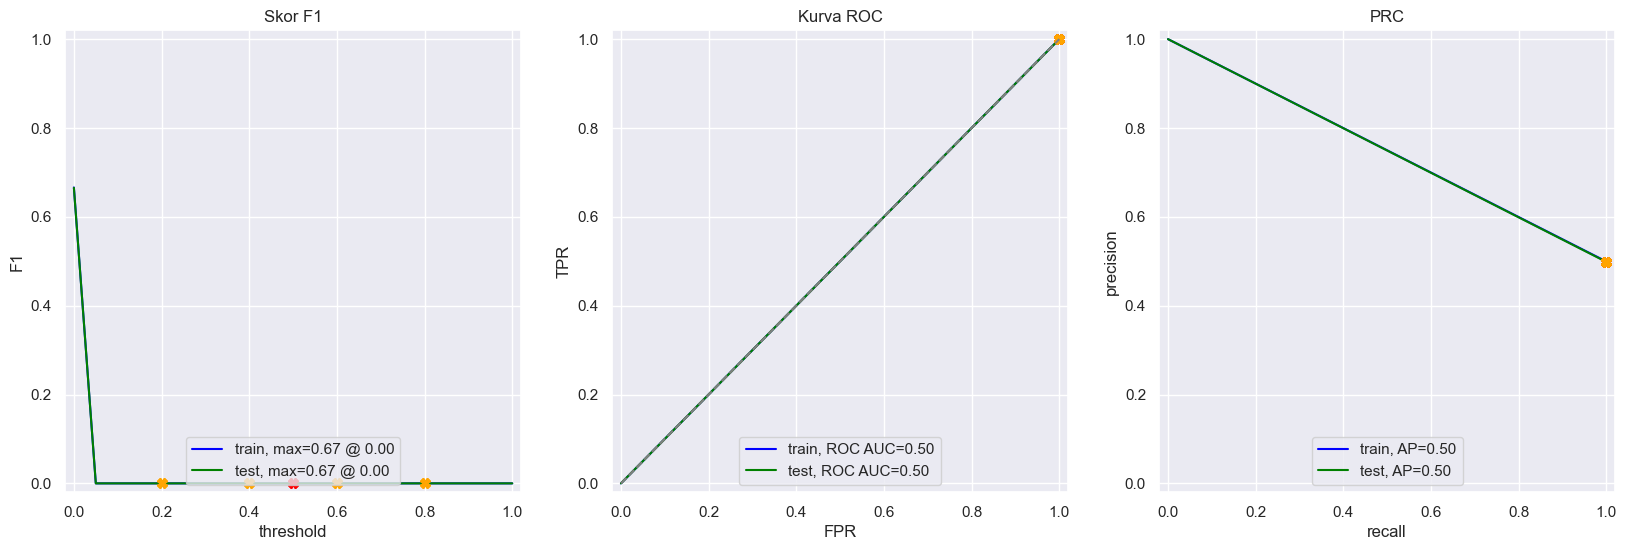

In [41]:
# evaluate model-0 dummyclassifier
eval_0 = evaluate_model(model_0, X_train, train_target, X_test, test_target)

It can be seen that almost all the scores for the test data show the number `0.5` except for `F1 score`. This model shows a poor model in term of prediction.

### Model 1 - NLTK, TF-IDF and LR <a id='cont_9'></a>

This model works using the word processing technique of `NLTK` to remove `stopwords` and also `lemate` the words. After processing, it is vectorized using TF-IDF from the `scikit-learn` module. A model from the same module such as `LogisticRegression` is trained, tested, and then evaluated.

In [42]:
# load some modules for model-1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fuada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fuada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# define stopwords and lematizers
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# create pre-processing for model-1
def text_preprocessing_1(text):
    words = word_tokenize(text)                                 # text tokenization
    words = [word for word in words if word not in stop_words]  # remove stop_words
    words = [lemmatizer.lemmatize(word) for word in words]      # word lematization
    return ' '.join(words)

# transform the dataset using the model-1 pre-processing function
transformed_train_1 = X_train.apply(text_preprocessing_1)
transformed_test_1 = X_test.apply(text_preprocessing_1)

# perform feature vectorization on each dataset
tfidf_vectorizer_1 = TfidfVectorizer()
train_features_1 = tfidf_vectorizer_1.fit_transform(transformed_train_1)
test_features_1 = tfidf_vectorizer_1.transform(transformed_test_1)

# train a logistic regression model
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


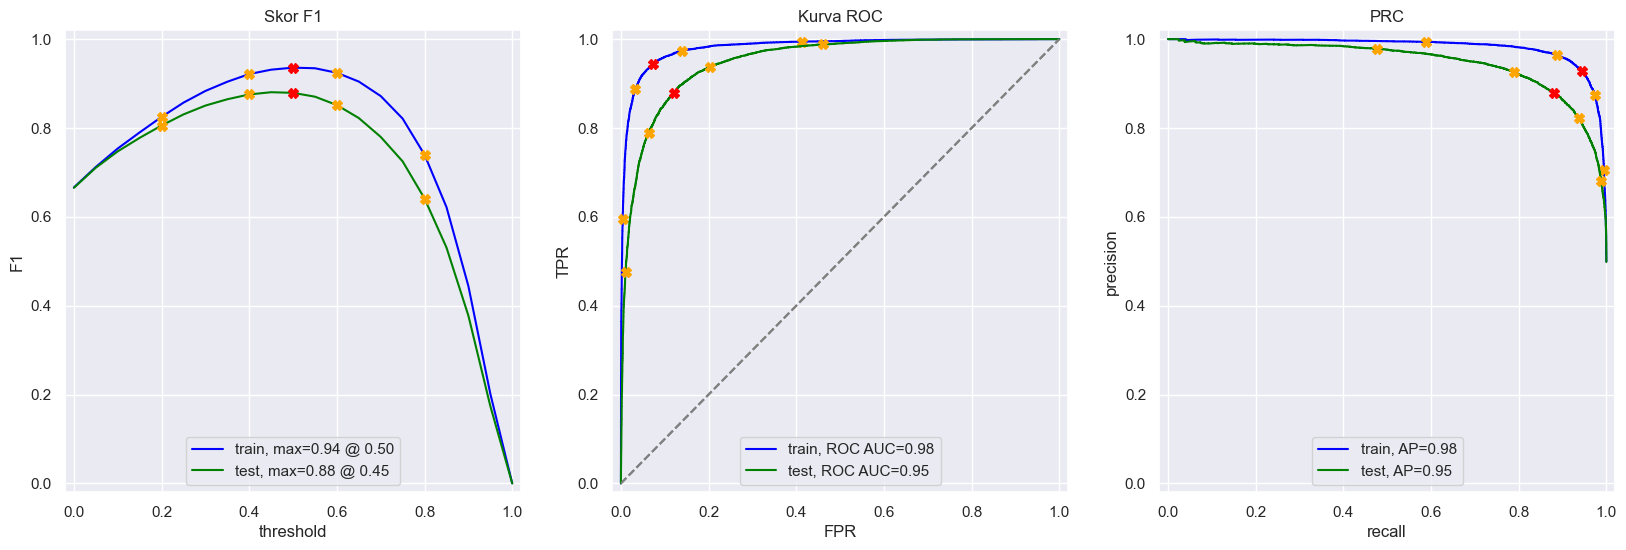

In [44]:
# evaluate model-1 logistic regression
eval_1 = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

We can see the performance of `model-1`, all the scores for the `test` dataset range from `0.88` to `0.95` showing very good performance. Based on the graph, `model-1` does not show any signs of `overfit` because the `train` and `test` scores are almost equal.

### Model 2 - spaCy, TF-IDF and LR <a id='cont_10'></a>

This model works using the word processing technique of `spaCy` to remove `stopwords` and `lemate` the words. After processing, it is vectorized using TF-IDF from the `scikit-learn` module. A model from the same module such as `LogisticRegression` is trained, tested, and then evaluated.

In [45]:
# load spacy module
import spacy

In [46]:
# defines a spacy module
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# create pre-processing for model-2
def text_preprocessing_2(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# transform the dataset using model-2 pre-processing function
transformed_train_2 = X_train.apply(text_preprocessing_2)
transformed_test_2 = X_test.apply(text_preprocessing_2)

# perform feature vectorization on each dataset
tfidf_vectorizer_2 = TfidfVectorizer()
train_features_2 = tfidf_vectorizer_2.fit_transform(transformed_train_2)
test_features_2 = tfidf_vectorizer_2.transform(transformed_test_2)

In [47]:
# train a logistic regression model
model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


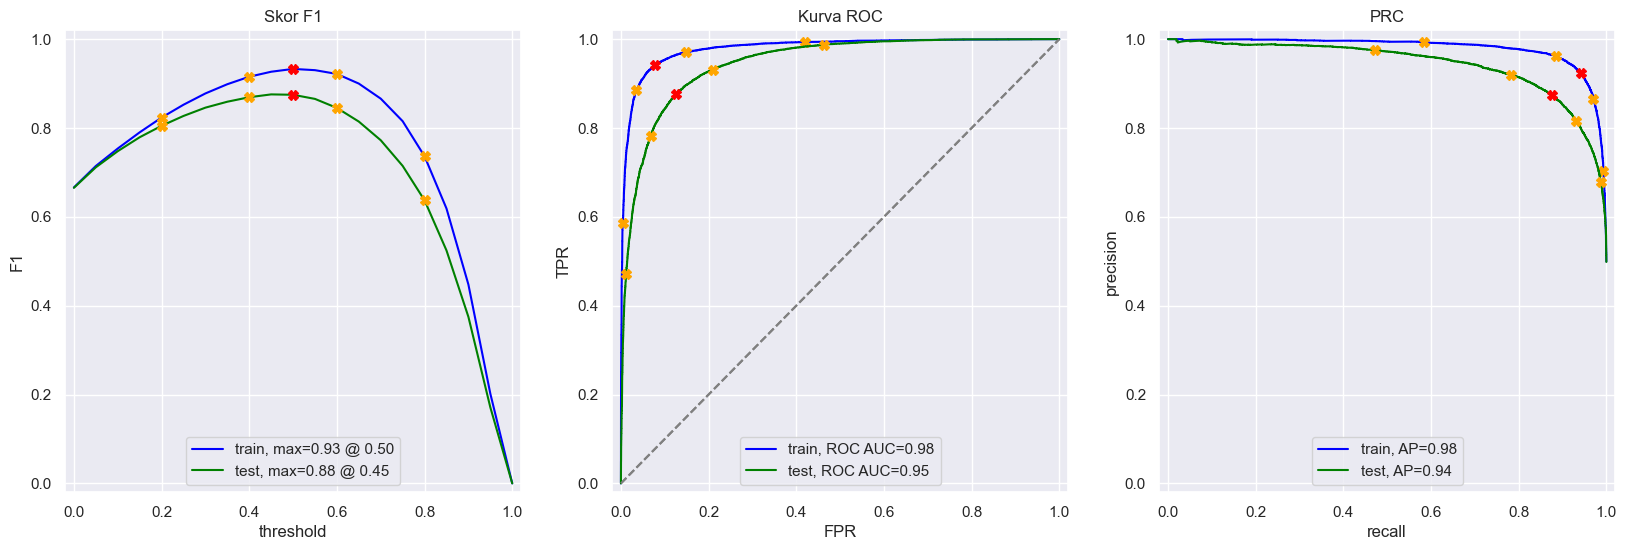

In [48]:
# evaluate model-2 logistic regression
eval_2 = evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

We can see the performance of this `model-2`, all the scores for the `test` dataset range from `0.87` to `0.95` showing very good performance. Based on the graph, the `model-2` does not show any signs of `overfit` because the `train` and `test` scores are almost equal.

### Model 3 - spaCy, TF-IDF and LGBMClassifier <a id='cont_11'></a>

Similarly, model-2 uses the word processing technique of `spaCy` to remove `stopwords` and `lemate` the words. After processing, it is vectorized using TF-IDF from the `scikit-learn` module. The model used is derived from the `LightGBM` module using the `LGBMClassifier` to train and test.

In [49]:
# load lgbm module
from lightgbm import LGBMClassifier

In [50]:
# train the LGBMClassifier model
model_3 = LGBMClassifier(learning_rate=0.2,n_estimators=250)
model_3.fit(train_features_2,train_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.642805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434948
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9268
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(learning_rate=0.2, n_estimators=250)

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


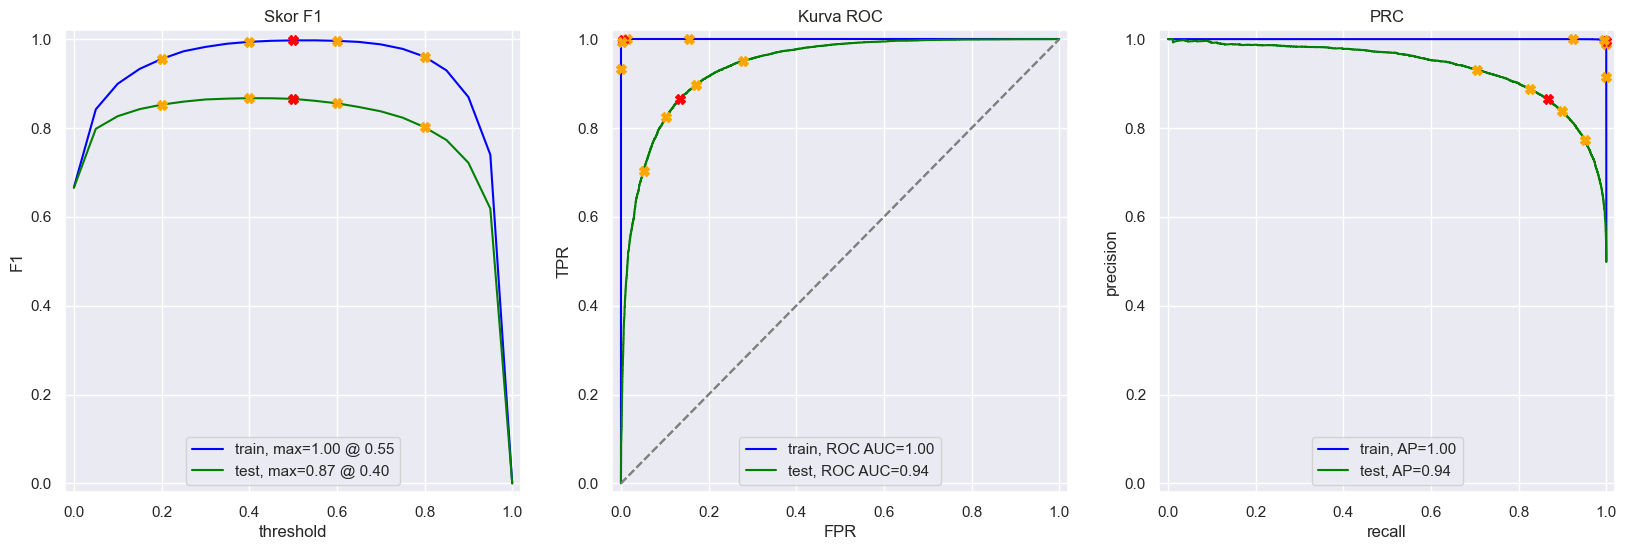

In [51]:
# evaluate model-3 LGBMClassifier
eval_3 = evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

We can see the performance of this `model-3`, all the scores for the `test` dataset range from `0.87` to `0.94` showing very good performance. Based on the graph, `model-3` shows signs of `overfit` because the `train` and `test` scores are almost unequal where the score for the `train` dataset is perfect.

###  Model 4 - BERT (Bidirectional Encoder Representations from Transformers) and LR <a id='cont_12'></a>

Unlike the previous models, this model uses the `BERT` technique to process data and uses the `BERT` model which has been trained to process words. This model will vectorize words by involving its right and left neighbors in its vectorization using a special encoder in the `transformers` module. After pre-processing, it is followed by training and testing the `LogisticRegression` model. This model was chosen because it produces a good score and is not too `overfit`.

#### Small Number of Samples <a id='cont_13'></a>

Here, we will test the model using a small samples of data due to the long computation time when using large datasets. We will use `100 samples` as an experiment. We will ensure that the classes in the `training` and `test` datasets have class balance.

In [52]:
# loading modules for BERT models
import torch
import transformers
from sklearn.model_selection import train_test_split

In [53]:
# define model, config, tokenizer and number of samples
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
max_sample_size = 100

In [54]:
# duplicating the train dataset
df_reviews_train = df_reviews_train.reset_index(drop=True).copy()
train_target = train_target.reset_index(drop=True).copy()

# divide the training dataset by 50 with the same class proportion
df_reviews_train_1 = df_reviews_train[df_reviews_train['pos'] == 1]
df_reviews_train_0 = df_reviews_train[df_reviews_train['pos'] == 0]
train_bert = pd.concat([df_reviews_train_0[:int(max_sample_size/4)]['review_norm'],df_reviews_train_1[:int(max_sample_size/4)]['review_norm']],axis=0)
target_train_bert = df_reviews_train.iloc[train_bert.index].copy()
target_train_bert['pos'].value_counts()

pos
0    25
1    25
Name: count, dtype: int64

In [55]:
# duplicating the test dataset
df_reviews_test = df_reviews_test.reset_index(drop=True).copy()
test_target = test_target.reset_index(drop=True).copy()

# divide the training dataset by 50 with the same class proportion
df_reviews_test_1 = df_reviews_test[df_reviews_test['pos'] == 1]
df_reviews_test_0 = df_reviews_test[df_reviews_test['pos'] == 0]
test_bert = pd.concat([df_reviews_test_0[:int(max_sample_size/4)]['review_norm'],df_reviews_test_1[:int(max_sample_size/4)]['review_norm']],axis=0)
target_test_bert = df_reviews_test.iloc[test_bert.index].copy()
target_test_bert['pos'].value_counts()

pos
0    25
1    25
Name: count, dtype: int64

The number of review classes for the training and test datasets are balanced. We will combine the two datasets into one for both `feature` and `target`.

In [56]:
# combine train and test datasets
features_bert = pd.concat([train_bert,test_bert],axis=0)
target_bert = pd.concat([target_train_bert['pos'],target_test_bert['pos']],axis=0)

print(features_bert.shape)
print(target_bert.shape)

(100,)
(100,)


The number is in accordance with what we describe as the number of samples at the beginning of `100 samples`. Next we will create a function to perform word preprocessing using the `BERT` model.

In [57]:
# define a function to process the words using BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # text to id token which has been padded along with the attention mask
    max_length = 512
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Use {device} for device.')
    
    # get embedding in batch
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    return np.concatenate(embeddings)

In [58]:
# Attention! Running BERT for thousands of texts may take a long time on the CPU, at least a few hours
transformed_features_bert = BERT_text_to_embeddings(features_bert)

Use cpu for device.


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\fuada\AppData\Local\Temp\ipykernel_20416\4114003298.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [59]:
# divide the dataset that has been pre-processed using BERT into train and test with a balanced number of review classes
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(transformed_features_bert,target_bert,test_size=0.2,stratify=target_bert,random_state=42)

print(y_train_bert.value_counts())
print(y_test_bert.value_counts())

pos
0    40
1    40
Name: count, dtype: int64
pos
1    10
0    10
Name: count, dtype: int64


In [60]:
# train a logistic regression model
model_4 = LogisticRegression()
model_4.fit(X_train_bert,y_train_bert)

LogisticRegression()

          train  test
Accuracy    1.0  0.85
F1          1.0  0.86
APS         1.0  0.90
ROC AUC     1.0  0.90


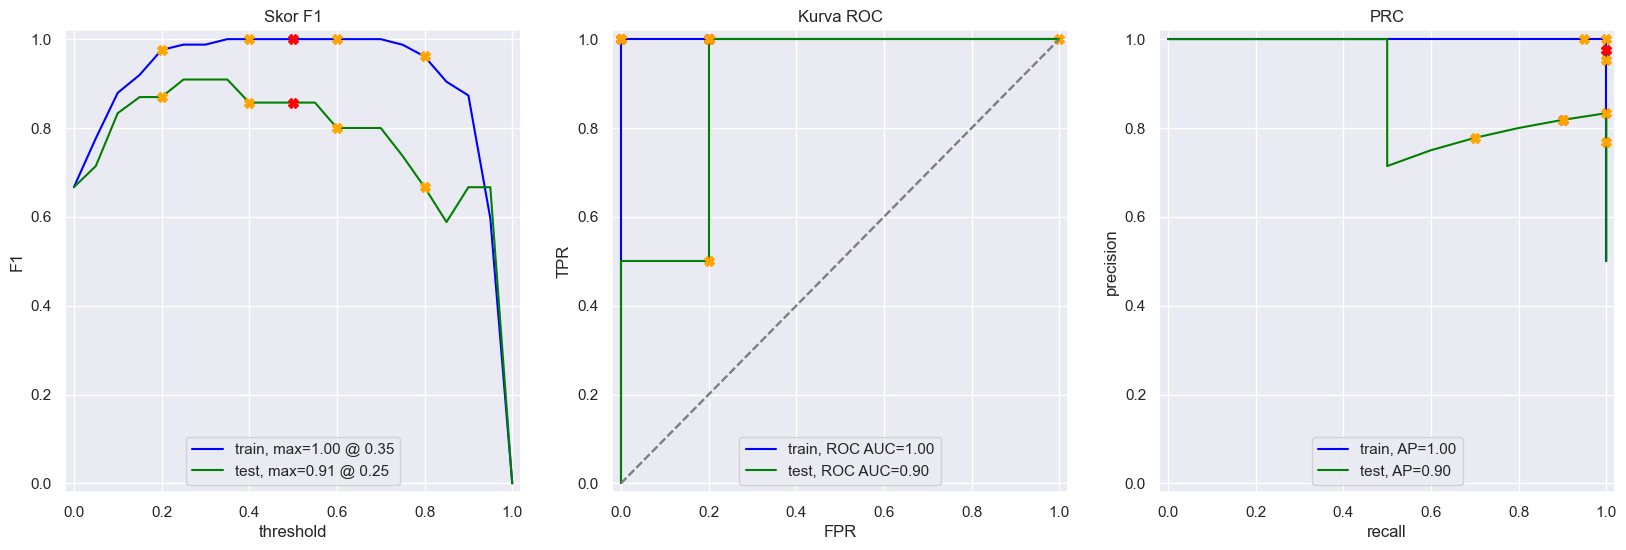

In [61]:
# evaluate LogisticRegression-4 model
eval_4 = evaluate_model(model_4, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

We can see the performance of this `model-4`, all the scores for the `test` dataset range from `0.85` to `0.90` showing very good performance. Based on the graph, the `model-4` with a slightly less good number of samples gives a score, it can be seen that the score graph is not `smooth` and also shows signs of `overfit`.

#### Large Number of Samples <a id='cont_14'></a>

Next, we will process the BERT model using a large number of samples. The number of samples to be processed is around `47199 samples` or almost all datasets. Due to the long computing time when using a personal laptop. We will use the `GPU` facility of `Google Colab` for word processing and have got the result in the form of `features_4.npz` file. We just run it and train our model.

In [62]:
# if you got the embedding, it's recommended to save it so it's ready
# np.savez_compressed('features_4.npz', train_features=transformed_features_bert, test_features=test_target_bert)

# and load...
# with np.load('features_4.npz') as data:
#     transformed_features_bert = data['transformed_features_bert']
#     target_bert = data['target_bert']

In [63]:
# load the results from features_4.npz
with np.load('features_4.npz') as data:
    large_features_bert = data['train_features']
    large_target_bert = data['test_features']

print(large_features_bert.shape)
print(large_target_bert.shape)

(47199, 768)
(47199,)


In [64]:
# divide the dataset that has been pre-processed using BERT into train and test with a balanced number of review classes
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(large_features_bert,large_target_bert,test_size=0.2,stratify=large_target_bert,random_state=42)

# train a logistic regression model
model_5 = LogisticRegression()
model_5.fit(X_train_bert,y_train_bert)

c:\Users\fuada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


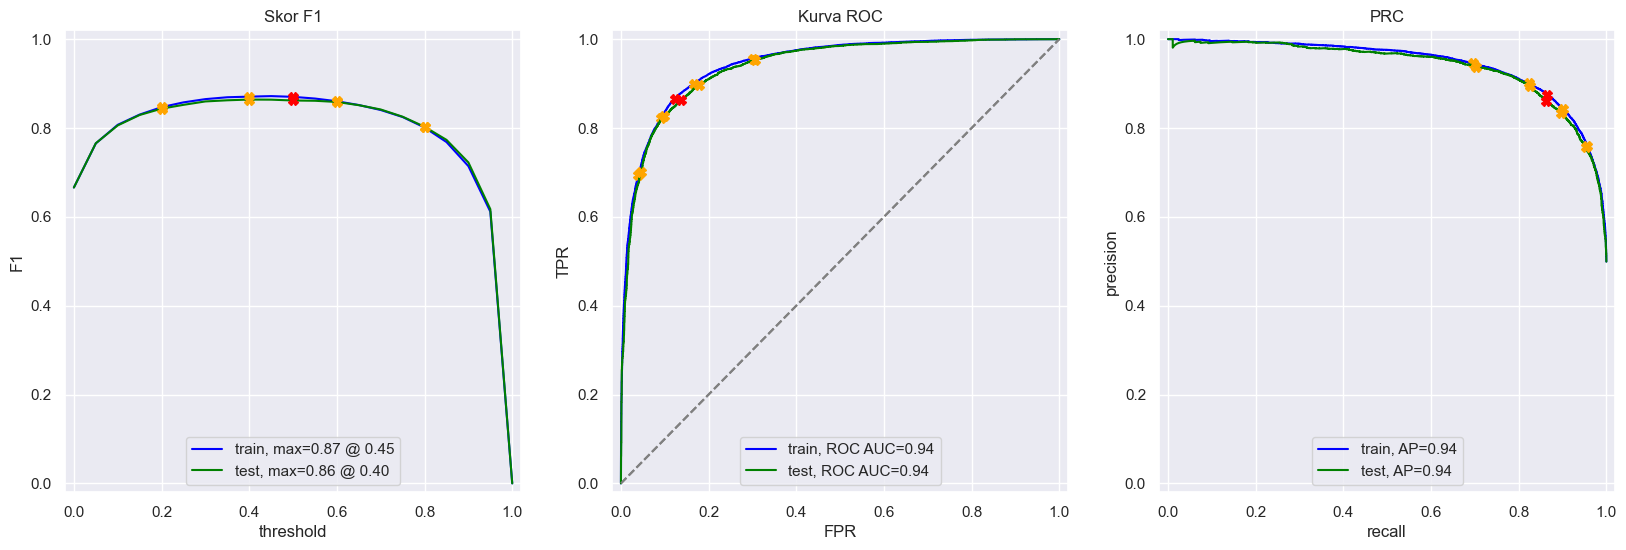

In [65]:
# evaluate the LogisticRegression-5 model
eval_5 = evaluate_model(model_5, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

We can see the performance of this `model-5`, all scores for the `test` dataset range from `0.86` to `0.94` showing very good performance. Based on the graph, the `model-5` shows no signs of `overfit` because the `train` and `test` scores are almost equal or even almost equal.

In [66]:
# filter the test result evaluation on model-0
model_0_acu = eval_0.iloc[0]['test']
model_0_f1 = eval_0.iloc[1]['test']
model_0_APS = eval_0.iloc[2]['test']
model_0_ROC_AUC = eval_0.iloc[3]['test']

# filter the test result evaluation on model-1
model_1_acu = eval_1.iloc[0]['test']
model_1_f1 = eval_1.iloc[1]['test']
model_1_APS = eval_1.iloc[2]['test']
model_1_ROC_AUC = eval_1.iloc[3]['test']

# filter the test result evaluation on model-2
model_2_acu = eval_2.iloc[0]['test']
model_2_f1 = eval_2.iloc[1]['test']
model_2_APS = eval_2.iloc[2]['test']
model_2_ROC_AUC = eval_2.iloc[3]['test']

# filter the test result evaluation on model-3
model_3_acu = eval_3.iloc[0]['test']
model_3_f1 = eval_3.iloc[1]['test']
model_3_APS = eval_3.iloc[2]['test']
model_3_ROC_AUC = eval_3.iloc[3]['test']

# filter the test result evaluation on model-5
model_5_acu = eval_5.iloc[0]['test']
model_5_f1 = eval_5.iloc[1]['test']
model_5_APS = eval_5.iloc[2]['test']
model_5_ROC_AUC = eval_5.iloc[3]['test']

In [67]:
# create a comparison table
table_comp = pd.DataFrame(data = {
    'model' : ['model-0','model-1','model-2','model-3','model-5'],
    'Accuracy': [model_0_acu,model_1_acu,model_2_acu,model_3_acu,model_5_acu],
    'F1 ': [model_0_f1,model_1_f1,model_2_f1,model_3_f1,model_5_f1],
    'APS': [model_0_APS,model_1_APS,model_2_APS,model_3_APS,model_5_APS],
    'ROC AUC': [model_0_ROC_AUC,model_1_ROC_AUC,model_2_ROC_AUC,model_3_ROC_AUC,model_5_ROC_AUC]
}, index=['Dummy','NLTK_TFIDF_LR','spaCy_TFIDF_LR','spaCy_TFIDF_LGBM','BERT_LR'])

# displays the comparison table
table_comp

,model,Accuracy,F1,APS,ROC AUC
Dummy,model-0,0.50,0.00,0.50,0.50
NLTK_TFIDF_LR,model-1,0.88,0.88,0.95,0.95
spaCy_TFIDF_LR,model-2,0.87,0.87,0.94,0.95
spaCy_TFIDF_LGBM,model-3,0.87,0.87,0.94,0.94
BERT_LR,model-5,0.86,0.86,0.94,0.94


We can conclude that some of the models we trained and tested passed the score we set, namely `F1 >= 0.85`. The passed models include `model-1`, `model-2`, `model-3` and `model-5`. If we sort the models from the best to the best by considering the score and any signs of overfit: `model-1` > `model-2` > `model-5` > `model-3`.

## Custom Reviews <a id='cont_15'></a>

Here, we will try to test the models that we have created and have been trained using manually generated reviews to identify whether these reviews are `positive` or `negative`.

In [68]:
# create custom reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# normalize the text
my_reviews['review_norm'] = my_reviews['review'].apply(pre_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


We can conclude that the `positive` reviews are at `index [2,4,7]` while the `negative` reviews are at `index [0,1,3,6]`. We will create a `threshold` of `0.5` as a barrier between the `positive` and `negative` reviews.

### Model 1 <a id='cont_16'></a>

In [69]:
# testing on model-1
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Based on the predictions of model-1, we can conclude that the `positive` reviews taking into account the `threshold` are at `index [2,7]` while the `negative` reviews are at `index [0,1,3,4,5,6]` . This model is correct 7 and incorrect 1.

### Model 2 <a id='cont_17'></a>

In [70]:
# testing on model-2
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn t expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Based on the predictions of model-2, we can conclude that the `positive` reviews taking into account the `threshold` are at `index [2,7]` while the `negative` reviews are at `index [0,1,3,4,5,6]` . This model is correct 7 and incorrect 1.

### Model 3 <a id='cont_18'></a>

In [71]:
# testing on model-3
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  i did not simply like it not my kind of movie
0.11:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.18:  i didn t expect the reboot to be so good writers really cared about the source material
0.72:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Based on the predictions of model-3 we can conclude that the `positive` reviews taking into account the `threshold` are at `index [0,2,5,7]` while the `negative` reviews are at `index [1,3,4,6]` . This model is correct 5 and incorrect 3.

### Model 5 <a id='cont_19'></a>

In [72]:
# testing on model-5
texts = my_reviews['review_norm']
my_reviews_features_4 = BERT_text_to_embeddings(texts, disable_progress_bar=True)
my_reviews_pred_prob = model_5.predict_proba(my_reviews_features_4)[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Based on the predictions of model-5, we can conclude that the `positive` reviews taking into account the `threshold` are at `index [2,5,7]` while the `negative` reviews are at `index [0,1,3,4,6]` . This model is correct 6 and incorrect 2.

Based on this, it shows that `model-1` gives the best prediction results where `true 7` and `false 1`. If we lower the `threshold` to `0.4`, then `model-1` will give `all correct answers`.

## Conclusion <a id='cont_20'></a>

In this project we have learned to do `dataset checking`, `EDA`, `word pre-processing`, `word vectorization`, do `model training`, and `model evaluation`. All processes run well, the data has `no duplication`, the data has `missing values can be ignored`, the number of `positive` and `negative` reviews is balanced, and also the number of `train` and `test` datasets is balanced. There are several conclusions that we can get from this project:
- Almost `every year there has been an increase in the number of movies` followed by an `increased number of reviews` for the movie with a ratio of `positive reviews` and `negative reviews` which was almost `balanced` until `2006`. The average number of reviews every `5 years` shows a `trend` which is `slightly increasing` from previous years to the highest average peak of `2010` more than `3000 reviews`.
- On average, most movies have `1-5 reviews/movie`, followed by movies with `30 reviews/movie` and followed after.
- Balanced comparison of the number of `movie ratings`, both for the `training` dataset and `test` dataset with the highest number of ratings being `1 and 10` for both datasets.
- The forms of the `training` and `test` datasets are similar based on the number of `positive reviews` and the number of `negative reviews`. A nearly even comparison of the number of `positive` reviews and the number of `negative` reviews for each dataset.
- Some of the models we train and test pass the score we set, namely `F1 >= 0.85`. The passed models include `model-1`, `model-2`, `model-3` and `model-5`. If we sort the models from the best to the best by considering the score and any signs of overfit: `model-1` > `model-2` > `model-5` > `model-3`.
- The `Custom Reviews` sub-chapter shows that `model-1` gives the best prediction results where `correct 7` and `false 1`. If we lower the `threshold` to `0.4`, then `model-1` will give `all correct answers`.